<a href="https://colab.research.google.com/github/Goutham-IITJ/Primetrade.ai/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
fg_df = pd.read_csv('/content/fear_greed_index.csv')
hd_df = pd.read_csv('/content/historical_data.csv')

print("Fear/Greed Data Loaded: ", fg_df.shape)
print("Historical Data Loaded: ", hd_df.shape)

Fear/Greed Data Loaded:  (2644, 4)
Historical Data Loaded:  (102574, 16)


In [2]:
# Clean and standardise Dates
# Fear/Greed date format is already YYYY-MM-DD
fg_df['Date'] = pd.to_datetime(fg_df['date']).dt.date

# Historical data has 'Timestamp IST', e.g., '02-12-2024 22:50'
hd_df['Date'] = pd.to_datetime(hd_df['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.date

# Check for any parsing issues
print("Unparseable dates in historical data:", hd_df['Date'].isnull().sum())

Unparseable dates in historical data: 0


In [3]:
# Mark winning/losing trades (PnL != 0 to count as a closed trade)
hd_df['Is_Closed_Trade'] = hd_df['Closed PnL'] != 0
hd_df['Is_Win'] = hd_df['Closed PnL'] > 0
hd_df['Is_Loss'] = hd_df['Closed PnL'] < 0

# Group by Date and Account to get daily stats
daily_stats = hd_df.groupby(['Date', 'Account']).agg(
    Daily_PnL=('Closed PnL', 'sum'),
    Total_Fee=('Fee', 'sum'),
    Total_Trade_Size_USD=('Size USD', 'sum'),
    Avg_Trade_Size_USD=('Size USD', 'mean'),
    Trade_Count=('Account', 'count'),
    Buy_Count=('Side', lambda x: (x == 'BUY').sum()),
    Sell_Count=('Side', lambda x: (x == 'SELL').sum()),
    Winning_Trades=('Is_Win', 'sum'),
    Closed_Trades=('Is_Closed_Trade', 'sum')
).reset_index()

# Derive Win Rate
daily_stats['Win_Rate'] = np.where(daily_stats['Closed_Trades'] > 0,
                                   daily_stats['Winning_Trades'] / daily_stats['Closed_Trades'],
                                   np.nan)

# Derive Long/Short Ratio
daily_stats['Long_Short_Ratio'] = np.where(daily_stats['Sell_Count'] > 0,
                                           daily_stats['Buy_Count'] / daily_stats['Sell_Count'],
                                           daily_stats['Buy_Count']) # If 0 sells, ratio represents total buys

# Clean up infinite values
daily_stats['Long_Short_Ratio'] = daily_stats['Long_Short_Ratio'].replace([np.inf, -np.inf], np.nan)

print("Daily metrics calculated successfully!")

Daily metrics calculated successfully!


In [4]:
# Merge with Fear/Greed Index
merged_df = pd.merge(daily_stats, fg_df[['Date', 'value', 'classification']], on='Date', how='inner')
merged_df.rename(columns={'value': 'FG_Index', 'classification': 'FG_Classification'}, inplace=True)

# Simplify Sentiment Classification to 3 main buckets
def group_sentiment(c):
    if 'Fear' in c: return 'Fear'
    elif 'Greed' in c: return 'Greed'
    else: return 'Neutral'

merged_df['Sentiment'] = merged_df['FG_Classification'].apply(group_sentiment)

# View the merged data
merged_df.head()

,Date,Account,Daily_PnL,Total_Fee,Total_Trade_Size_USD,Avg_Trade_Size_USD,Trade_Count,Buy_Count,Sell_Count,Winning_Trades,Closed_Trades,Win_Rate,Long_Short_Ratio,FG_Index,FG_Classification,Sentiment
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,0.000000,477.00,159.000000,3,3,0,0,0,NaN,3.000000,63,Greed,Greed
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,12.501455,50005.83,5556.203333,9,7,2,0,0,NaN,3.500000,75,Extreme Greed,Greed
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737,28.300831,113203.35,10291.213636,11,5,6,4,6,0.666667,0.833333,72,Greed,Greed
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034,2.652489,10609.95,5304.975000,2,2,0,0,2,0.000000,2.000000,70,Greed,Greed
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,3.837189,15348.77,5116.256667,3,3,0,0,0,NaN,3.000000,67,Greed,Greed


--- Overall Stats by Sentiment ---


,Sentiment,Avg_Daily_PnL,Median_Daily_PnL,Avg_Win_Rate,Avg_Trade_Count,Avg_Trade_Size,Avg_LS_Ratio
0,Fear,8583.583154,134.828440,0.887176,113.331476,8346.435154,11.330170
1,Greed,4879.009751,213.454550,0.879914,59.445748,8207.106776,6.150749
2,Neutral,5689.539340,251.604742,0.885889,105.123153,9351.363986,9.683897


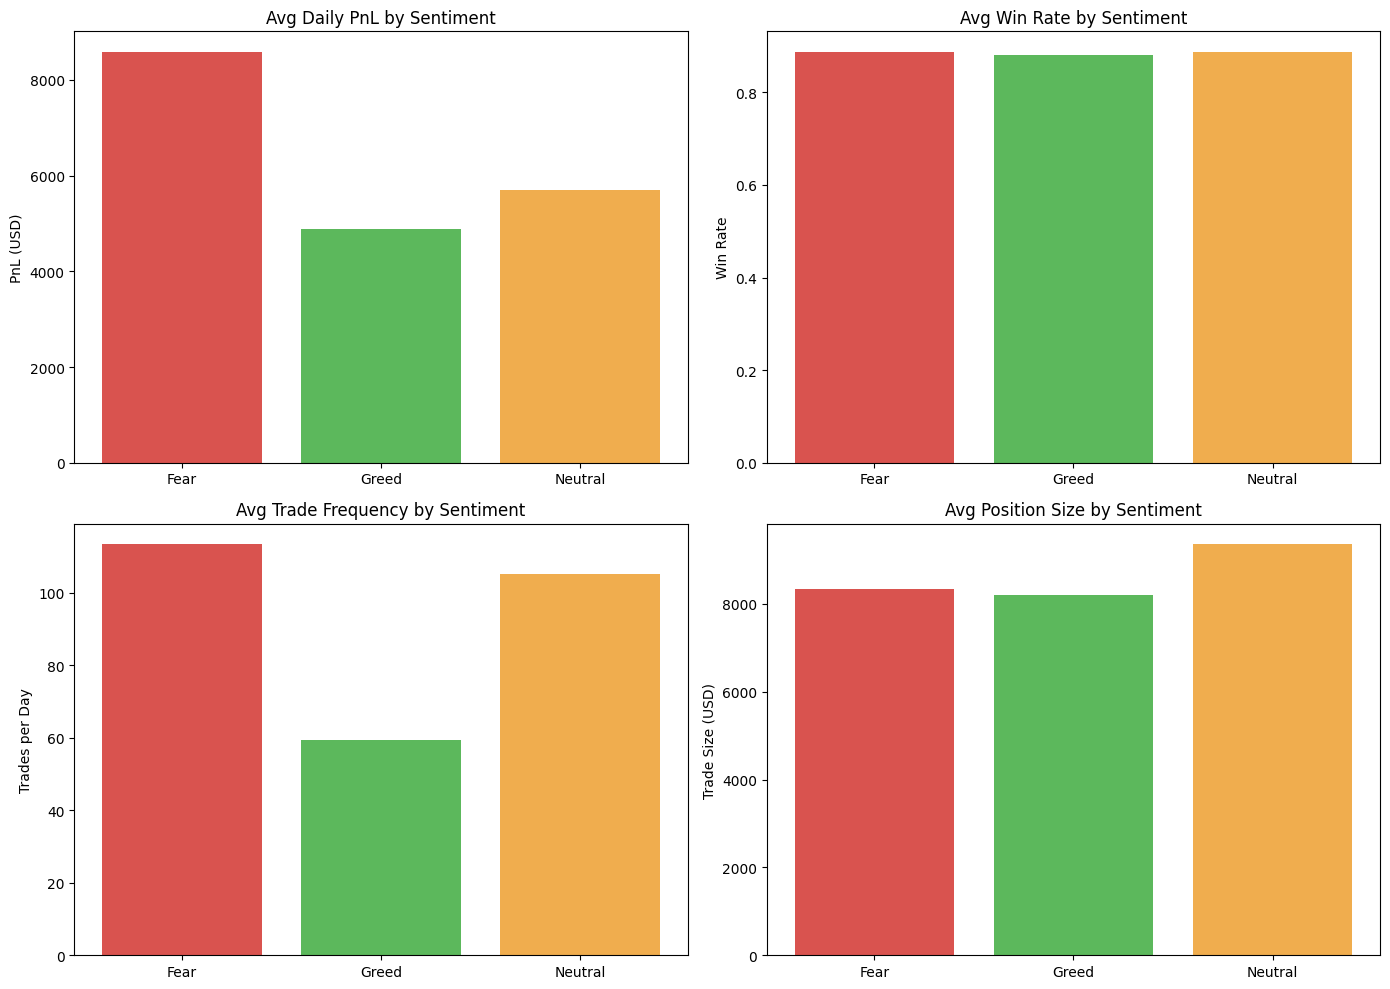

In [5]:
# Group by Sentiment
sentiment_stats = merged_df.groupby('Sentiment').agg(
    Avg_Daily_PnL=('Daily_PnL', 'mean'),
    Median_Daily_PnL=('Daily_PnL', 'median'),
    Avg_Win_Rate=('Win_Rate', 'mean'),
    Avg_Trade_Count=('Trade_Count', 'mean'),
    Avg_Trade_Size=('Avg_Trade_Size_USD', 'mean'),
    Avg_LS_Ratio=('Long_Short_Ratio', 'mean')
).reset_index()

print("--- Overall Stats by Sentiment ---")
display(sentiment_stats)

# Visualizations
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Avg Daily PnL
axs[0,0].bar(sentiment_stats['Sentiment'], sentiment_stats['Avg_Daily_PnL'], color=['#d9534f', '#5cb85c', '#f0ad4e'])
axs[0,0].set_title('Avg Daily PnL by Sentiment')
axs[0,0].set_ylabel('PnL (USD)')

# Avg Win Rate
axs[0,1].bar(sentiment_stats['Sentiment'], sentiment_stats['Avg_Win_Rate'], color=['#d9534f', '#5cb85c', '#f0ad4e'])
axs[0,1].set_title('Avg Win Rate by Sentiment')
axs[0,1].set_ylabel('Win Rate')

# Avg Trade Count
axs[1,0].bar(sentiment_stats['Sentiment'], sentiment_stats['Avg_Trade_Count'], color=['#d9534f', '#5cb85c', '#f0ad4e'])
axs[1,0].set_title('Avg Trade Frequency by Sentiment')
axs[1,0].set_ylabel('Trades per Day')

# Avg Trade Size
axs[1,1].bar(sentiment_stats['Sentiment'], sentiment_stats['Avg_Trade_Size'], color=['#d9534f', '#5cb85c', '#f0ad4e'])
axs[1,1].set_title('Avg Position Size by Sentiment')
axs[1,1].set_ylabel('Trade Size (USD)')

plt.tight_layout()
plt.show()


--- Segment Analysis: Frequency Segment ---


,Frequency_Segment,Sentiment,Avg_Daily_PnL
0,Frequent,Fear,10423.517361
1,Frequent,Greed,4964.274403
2,Frequent,Neutral,6490.975057
3,Infrequent,Fear,4072.206013
4,Infrequent,Greed,4548.913740
5,Infrequent,Neutral,3101.569836


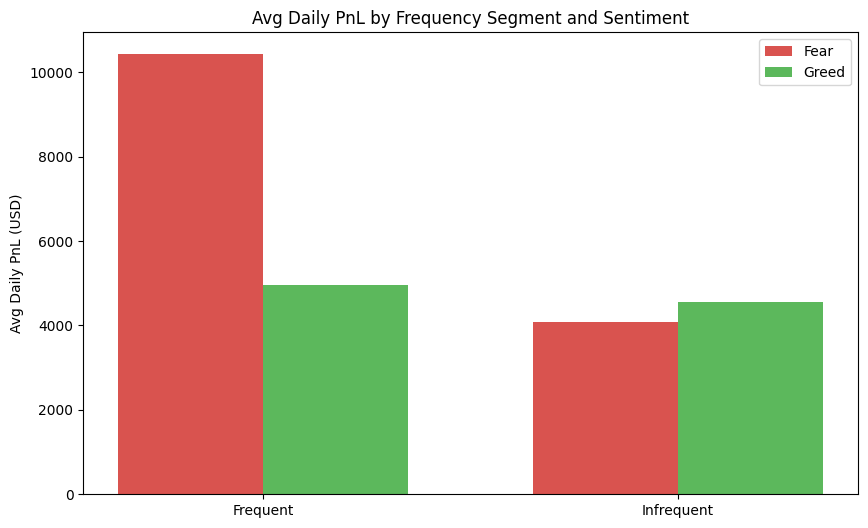

In [6]:
# Calculate lifetime stats per trader for segmentation
trader_totals = merged_df.groupby('Account').agg(
    Total_Trades=('Trade_Count', 'sum'),
    Total_PnL=('Daily_PnL', 'sum'),
    Avg_Win_Rate=('Win_Rate', 'mean')
).reset_index()

# 1. Frequency Segment (Split by median trade count)
median_trades = trader_totals['Total_Trades'].median()
trader_totals['Frequency_Segment'] = np.where(trader_totals['Total_Trades'] >= median_trades, 'Frequent', 'Infrequent')

# 2. Performance Segment (Win rate > 50% AND profitable overall)
trader_totals['Performance_Segment'] = np.where(
    (trader_totals['Avg_Win_Rate'] > 0.5) & (trader_totals['Total_PnL'] > 0),
    'Consistent Winner', 'Inconsistent/Loser'
)

# Merge segments back to main DataFrame
merged_df = pd.merge(merged_df, trader_totals[['Account', 'Frequency_Segment', 'Performance_Segment']], on='Account', how='left')

# Analyze segments behavior during fear vs greed
segment_stats = merged_df.groupby(['Frequency_Segment', 'Sentiment']).agg(
    Avg_Daily_PnL=('Daily_PnL', 'mean')
).reset_index()

print("\n--- Segment Analysis: Frequency Segment ---")
display(segment_stats)

# Plotting the Segment Analysis
freq_fear = segment_stats[segment_stats['Sentiment'] == 'Fear']
freq_greed = segment_stats[segment_stats['Sentiment'] == 'Greed']

fig2, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(freq_fear['Frequency_Segment']))
width = 0.35

ax.bar(x - width/2, freq_fear['Avg_Daily_PnL'], width, label='Fear', color='#d9534f')
ax.bar(x + width/2, freq_greed['Avg_Daily_PnL'], width, label='Greed', color='#5cb85c')
ax.set_xticks(x)
ax.set_xticklabels(freq_fear['Frequency_Segment'])
ax.set_title('Avg Daily PnL by Frequency Segment and Sentiment')
ax.set_ylabel('Avg Daily PnL (USD)')
ax.legend()

plt.show()